NN on vehicle

Fully connected


In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import matplotlib.pyplot as plt
# plot param
%matplotlib inline
plt.rcParams['figure.figsize'] = (28.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('ggplot')

First, manipulate the input and output data

For now, always assumme that the state represent by single dimension vector
in other word it only has one feature.

Meanwhile the action size should be check if there is non-determinism in which action the controller should choose (it will influence how the score/loss function will be calculated). For instance, when the state has two ND actions (0 and 1), the loss function of that sample should be zero if the predicted action is action[0] OR action[1].

For this vehicle case the input size is one (there is no ND on the actions).

The uniqueness of the actions would determine the size of the output layer neuron's size

In [2]:
# parse the controller file
f = open('../COTONN/vehicle_small_bdd/controller.scs', "r")

In [3]:
lines = []

In [4]:
for line in f:
    if '#MATRIX:DATA\n' in line:                
        for line in f: # now you are at the lines you want
            # skip the #BEGIN 
            # read the state-actions
            lines = f.readlines()

In [5]:
del lines[-1]

In [6]:
lines[-1]

'90667 5\n'

In [7]:
ltrain_dataset = []
ltrain_label = []

In [8]:
for x in lines:
    ltrain_dataset.append(x.split(' ')[0].strip('\n'))
    ltrain_label.append(x.split(' ')[1].strip('\n'))
f.close()

In [9]:
train_dataset = np.asarray(ltrain_dataset)
train_label = np.asarray(ltrain_label)

In [10]:
train_dataset = train_dataset.astype(np.float32)
train_label = train_label.astype(np.float32)

In [11]:
train_label.shape

(48158,)

In [12]:
train_dataset.shape

(48158,)

In [13]:
num_label = len(set(train_label))
num_label

18

In [14]:
lcoll_label = sorted(list(set(train_label)))

In [15]:
lcoll_label

[0.0,
 1.0,
 5.0,
 6.0,
 7.0,
 13.0,
 14.0,
 20.0,
 21.0,
 27.0,
 28.0,
 34.0,
 35.0,
 41.0,
 42.0,
 43.0,
 47.0,
 48.0]

In [16]:
lcoll_label.index(5)

2

In [17]:
train_dataset.shape

(48158,)

In [18]:
train_label

array([ 0.,  0.,  7., ..., 43., 43.,  5.], dtype=float32)

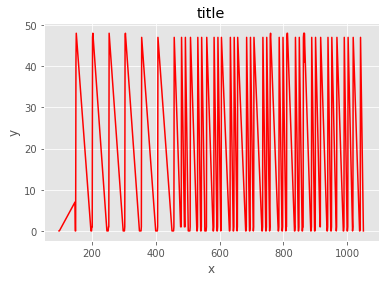

In [19]:
plt.plot(train_dataset[:200], train_label[:200], 'r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('title')
plt.show()

In [20]:
train_label_transformed = np.zeros_like(train_label)

In [21]:
for i in range(train_label.shape[0]):
    train_label_transformed[i] = lcoll_label.index(train_label[i])

In [22]:
train_label_transformed

array([ 0.,  0.,  4., ..., 15., 15.,  2.], dtype=float32)

In [23]:
train_dataset

array([   97.,    98.,   147., ..., 90665., 90666., 90667.], dtype=float32)

In [24]:
len(lcoll_label)

18

In [25]:
train_label_hot = (np.arange(len(lcoll_label)) == train_label_transformed[:, None]).astype(np.float32)

In [26]:
train_label_hot.shape

(48158, 18)

In [27]:
train_label_hot[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [28]:
train_dataset_reform_dim = train_dataset[:, None]

In [29]:
train_dataset_reform_dim.shape

(48158, 1)

BINARY

In [30]:
# training dataset

In [31]:
# set the upper limit of experiment
upper_limit = train_dataset_reform_dim.shape[0] #40
# upper_limit = 2*11*11*199
upper_limit

48158

In [32]:
# slice the samples
train_sliced = train_dataset_reform_dim[:upper_limit]
train_sliced

array([[   97.],
       [   98.],
       [  147.],
       ...,
       [90665.],
       [90666.],
       [90667.]], dtype=float32)

In [33]:
# change it to init
train_sliced_int = train_sliced.astype(np.uint32)
train_sliced_int

array([[   97],
       [   98],
       [  147],
       ...,
       [90665],
       [90666],
       [90667]], dtype=uint32)

In [34]:
tsi8_unordered = train_sliced_int.view(np.uint8)
tsi8 = np.flip(tsi8_unordered,1)
tsi8

array([[  0,   0,   0,  97],
       [  0,   0,   0,  98],
       [  0,   0,   0, 147],
       ...,
       [  0,   1,  98,  41],
       [  0,   1,  98,  42],
       [  0,   1,  98,  43]], dtype=uint8)

In [35]:
tsi8_unordered

array([[ 97,   0,   0,   0],
       [ 98,   0,   0,   0],
       [147,   0,   0,   0],
       ...,
       [ 41,  98,   1,   0],
       [ 42,  98,   1,   0],
       [ 43,  98,   1,   0]], dtype=uint8)

In [36]:
# converte to bit representation
# toy_vehicle_input = np.unpackbits(tu_u8, axis=1)
# toy_vehicle_input
toy_vehicle_input_unreduced = np.unpackbits(tsi8).reshape(-1,32)
toy_vehicle_input_unreduced

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 1]], dtype=uint8)

In [37]:
toy_vehicle_input = toy_vehicle_input_unreduced[:, np.arange(14,32)]
toy_vehicle_input.shape

(48158, 18)

In [38]:
num_samples = toy_vehicle_input.shape[0]
num_samples

48158

In [39]:
train_dataset_reform = toy_vehicle_input

In [40]:
train_dataset_reform.shape

(48158, 18)

In [41]:
train_label_hot.shape

(48158, 18)

In [42]:
train_dataset_reform.shape

(48158, 18)

Label

In [43]:
train_label_dim = train_label[:, None]

In [44]:
train_label_dim.shape

(48158, 1)

In [45]:
upper_limit

48158

In [46]:
# slice the samples
train_label_sliced = train_label_dim[:upper_limit]
train_label_sliced

array([[ 0.],
       [ 0.],
       [ 7.],
       ...,
       [43.],
       [43.],
       [ 5.]], dtype=float32)

In [47]:
# change it to int
train_label_sliced_int = train_label_sliced.astype(np.uint32)
train_label_sliced_int

array([[ 0],
       [ 0],
       [ 7],
       ...,
       [43],
       [43],
       [ 5]], dtype=uint32)

In [48]:
tsi8_label_unordered = train_label_sliced_int.view(np.uint8)
tsi8_label_unordered
# tsi8_label = np.flip(tsi8_label_unordered,1)
# tsi8_label

array([[ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 7,  0,  0,  0],
       ...,
       [43,  0,  0,  0],
       [43,  0,  0,  0],
       [ 5,  0,  0,  0]], dtype=uint8)

In [49]:
tsi8_label = np.flip(tsi8_label_unordered,1)
tsi8_label

array([[ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  7],
       ...,
       [ 0,  0,  0, 43],
       [ 0,  0,  0, 43],
       [ 0,  0,  0,  5]], dtype=uint8)

In [50]:
# converte to bit representation
# toy_vehicle_input = np.unpackbits(tu_u8, axis=1)
# toy_vehicle_input
toy_vehicle_label_unreduced = np.unpackbits(tsi8_label).reshape(-1,32)
toy_vehicle_label_unreduced

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 1, 0, 1]], dtype=uint8)

In [51]:
toy_vehicle_label = toy_vehicle_label_unreduced[:, np.arange(26,32)]
toy_vehicle_label.shape

(48158, 6)

In [52]:
toy_vehicle_label.shape

(48158, 6)

In [53]:
train_label_hot[:upper_limit].shape

(48158, 18)

In [54]:
num_label = toy_vehicle_label.shape[1]

In [55]:
# num_label = train_label_hot[:upper_limit].shape[1]

In [56]:
num_label

6

In [57]:
tf.reset_default_graph()

In [119]:
# 4 layer
# different number of output layer
batch_size = upper_limit
input_size = train_dataset_reform.shape[1]
hidden_size = 128
hidden_size2 = 128
hidden_size3 = 128
hidden_size4 = 128

"""
hidden_size5 = 128
hidden_size6 = 128
hidden_size7 = 128
hidden_size8 = 128
hidden_size9 = 128
"""

# graph = tf.Graph()
# with graph.as_default():
# Input data. For the training data, we use a placeholder that will be fed
# at run time with a training minibatch.
tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, input_size))
tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_label))

keep_prob = tf.placeholder(tf.float32)

# Variables.
weights1 = tf.Variable(tf.truncated_normal([input_size, hidden_size]))
biases1 = tf.Variable(tf.truncated_normal([hidden_size]))

weights2 = tf.Variable(tf.truncated_normal([hidden_size, hidden_size2]))
# biases2 = tf.Variable(tf.zeros([num_label]))
biases2 = tf.Variable(tf.truncated_normal([hidden_size2]))

weights3 = tf.Variable(tf.truncated_normal([hidden_size2, hidden_size3]))
biases3 = tf.Variable(tf.truncated_normal([hidden_size3]))
# weights3 = tf.Variable(tf.truncated_normal([hidden_size2, num_label]))
# biases3 = tf.Variable(tf.truncated_normal([num_label]))

weights4 = tf.Variable(tf.truncated_normal([hidden_size3, hidden_size4]))
biases4 = tf.Variable(tf.truncated_normal([hidden_size4]))

weights5 = tf.Variable(tf.truncated_normal([hidden_size4, num_label]))
biases5 = tf.Variable(tf.truncated_normal([num_label]))

"""
weights6 = tf.Variable(tf.truncated_normal([hidden_size5, hidden_size6]))
biases6 = tf.Variable(tf.truncated_normal([hidden_size6]))

weights7 = tf.Variable(tf.truncated_normal([hidden_size6, hidden_size7]))
biases7 = tf.Variable(tf.truncated_normal([hidden_size7]))

weights8 = tf.Variable(tf.truncated_normal([hidden_size7, hidden_size8]))
biases8 = tf.Variable(tf.truncated_normal([hidden_size8]))

weights9 = tf.Variable(tf.truncated_normal([hidden_size8, hidden_size9]))
biases9 = tf.Variable(tf.truncated_normal([hidden_size9]))

weights10 = tf.Variable(tf.truncated_normal([hidden_size9, num_label]))
biases10 = tf.Variable(tf.truncated_normal([num_label]))
"""

# Training computation.
logits1 = tf.matmul(tf_train_dataset, weights1) + biases1  

relu_act_func_d = tf.nn.sigmoid(logits1)
relu_act_func = tf.nn.dropout(relu_act_func_d, keep_prob)
logits2 = tf.matmul(relu_act_func_d, weights2) + biases2

relu_act_func2_d = tf.nn.sigmoid(logits2)
relu_act_func2 = tf.nn.dropout(relu_act_func2_d, keep_prob)
logits3 = tf.matmul(relu_act_func2_d, weights3) + biases3

relu_act_func3_d = tf.nn.sigmoid(logits3)
relu_act_func3 = tf.nn.dropout(relu_act_func3_d, keep_prob)
logits4 = tf.matmul(relu_act_func3_d, weights4) + biases4

relu_act_func4_d = tf.nn.sigmoid(logits4)
relu_act_func4 = tf.nn.dropout(relu_act_func4_d, keep_prob)
logits5 = tf.matmul(relu_act_func4_d, weights5) + biases5


"""
relu_act_func5_d = tf.nn.relu(logits5)
relu_act_func5 = tf.nn.dropout(relu_act_func5_d, keep_prob)
logits6 = tf.matmul(relu_act_func5_d, weights6) + biases6

relu_act_func6_d = tf.nn.relu(logits6)
relu_act_func6 = tf.nn.dropout(relu_act_func6_d, keep_prob)
logits7 = tf.matmul(relu_act_func6_d, weights7) + biases7

relu_act_func7_d = tf.nn.relu(logits7)
# dropout = tf.nn.dropout(relu_act_func7, keep_prob)
# logits8 = tf.matmul(dropout, weights8) + biases8
relu_act_func7 = tf.nn.dropout(relu_act_func7_d, keep_prob)
logits8 = tf.matmul(relu_act_func7_d, weights8) + biases8 

relu_act_func8_d = tf.nn.relu(logits8)
# dropout = tf.nn.dropout(relu_act_func7, keep_prob)
# logits8 = tf.matmul(dropout, weights8) + biases8
relu_act_func8 = tf.nn.dropout(relu_act_func8_d, keep_prob)
logits9 = tf.matmul(relu_act_func8_d, weights9) + biases9 

relu_act_func9_d = tf.nn.relu(logits9)
relu_act_func9 = tf.nn.dropout(relu_act_func9_d, keep_prob)
# dropout = tf.nn.dropout(relu_act_func7, keep_prob)
# logits8 = tf.matmul(dropout, weights8) + biases8
logits10 = tf.matmul(relu_act_func9_d, weights10) + biases10 
"""

logits = logits5
# loss = tf.reduce_mean(tf.losses.absolute_difference(labels=tf_train_labels, predictions=train_prediction))
# loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits3))
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))

loss_summary = tf.summary.scalar('loss', loss)

# Optimizer.
#optimizer = tf.train.GradientDescentOptimizer(0.0001).minimize(loss)
optimizer = tf.train.AdamOptimizer(0.005).minimize(loss)

# Predictions for the training, validation, and test data.
# train_prediction = tf.nn.softmax(logits3)
train_prediction = tf.round(tf.nn.sigmoid(logits))
# writer = tf.summary.FileWriter('./vehicle', tf.get_default_graph())

In [120]:
input_size

18

In [121]:
tf_train_dataset

<tf.Tensor 'Placeholder_18:0' shape=(48158, 18) dtype=float32>

In [122]:
tf_train_labels

<tf.Tensor 'Placeholder_19:0' shape=(48158, 6) dtype=float32>

In [123]:
iteration_one_epoch = np.floor(num_samples / batch_size)
iteration_one_epoch

1.0

In [124]:
def accuracy_multilabel(predictions, labels):
  return (100.0*np.mean(np.round(predictions) == np.round(batch_labels)))

In [125]:
num_samples

48158

In [126]:
num_batches = num_samples//batch_size
num_batches

1

In [127]:
epochs = 50

In [128]:
train_dataset_bin = train_dataset_reform.astype(np.float32)
train_dataset_bin

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 1.]], dtype=float32)

In [129]:
train_label_bin = toy_vehicle_label.astype(np.float32)
train_label_bin

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1.],
       ...,
       [1., 0., 1., 0., 1., 1.],
       [1., 0., 1., 0., 1., 1.],
       [0., 0., 0., 1., 0., 1.]], dtype=float32)

In [ ]:
# MINIBATCH GRADIENT DESCENT
loss_history = []
num_steps = int(iteration_one_epoch*50)

acc = 0
acc_cum = 0
acc_temp = 0
epoch_idx = 0

with tf.Session() as session:
#with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    while acc<100:
        epoch_idx += 1
        acc_cum = 0
        for step in range(num_batches):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size)
            # Generate a minibatch.
            batch_data = train_dataset_bin[offset:(offset + batch_size), :]
            # batch_labels = train_label_hot[offset:(offset + batch_size), :]
            batch_labels = train_label_bin[offset:(offset + batch_size), :]
            
            # batch_labels = train_label_hot[:upper_limit]
            # batch_data = train_dataset_reform
            # batch_labels = train_label_hot

            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels,  keep_prob : 1}
            # feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions, added_summary = session.run(
                [optimizer, loss, train_prediction, loss_summary], feed_dict=feed_dict)

            # writer.add_summary(added_summary)
            loss_history.append(l)
            acc_temp =  accuracy_multilabel(predictions, batch_labels)
            acc_cum += acc_temp
            acc = acc_cum/(step+1)
            print("Epoch {0:6d} Step: {1:6d} Loss: {2:8.4f} Training Acc: {3:8.2f} {4:8.2f} {5:8.2f}%".format(epoch_idx, step, l, acc_temp, acc_cum, acc))

            # print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            # print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Epoch      1 Step:      0 Loss:   3.7705 Training Acc:    44.26    44.26    44.26%
Epoch      2 Step:      0 Loss:   2.7656 Training Acc:    47.48    47.48    47.48%
Epoch      3 Step:      0 Loss:   2.0765 Training Acc:    53.54    53.54    53.54%
Epoch      4 Step:      0 Loss:   1.6497 Training Acc:    56.44    56.44    56.44%
Epoch      5 Step:      0 Loss:   1.3288 Training Acc:    57.28    57.28    57.28%
Epoch      6 Step:      0 Loss:   1.0355 Training Acc:    57.95    57.95    57.95%
Epoch      7 Step:      0 Loss:   0.8134 Training Acc:    59.71    59.71    59.71%
Epoch      8 Step:      0 Loss:   0.7797 Training Acc:    61.90    61.90    61.90%
Epoch      9 Step:      0 Loss:   0.8261 Training Acc:    61.01    61.01    61.01%
Epoch     10 Step:      0 Loss:   0.8606 Training Acc:    59.50    59.50    59.50%
Epoch     11 Step:      0 Loss:   0.8673 Training Acc:    58.26    58.26    58.26%
Epoch     12 Step:      0 Loss:   0.8452 Training Acc:    57.95    57.95   

Epoch    101 Step:      0 Loss:   0.6153 Training Acc:    66.19    66.19    66.19%
Epoch    102 Step:      0 Loss:   0.6151 Training Acc:    66.21    66.21    66.21%
Epoch    103 Step:      0 Loss:   0.6149 Training Acc:    66.23    66.23    66.23%
Epoch    104 Step:      0 Loss:   0.6148 Training Acc:    66.22    66.22    66.22%
Epoch    105 Step:      0 Loss:   0.6146 Training Acc:    66.22    66.22    66.22%
Epoch    106 Step:      0 Loss:   0.6145 Training Acc:    66.23    66.23    66.23%
Epoch    107 Step:      0 Loss:   0.6143 Training Acc:    66.24    66.24    66.24%
Epoch    108 Step:      0 Loss:   0.6142 Training Acc:    66.23    66.23    66.23%
Epoch    109 Step:      0 Loss:   0.6140 Training Acc:    66.23    66.23    66.23%
Epoch    110 Step:      0 Loss:   0.6139 Training Acc:    66.23    66.23    66.23%
Epoch    111 Step:      0 Loss:   0.6137 Training Acc:    66.24    66.24    66.24%
Epoch    112 Step:      0 Loss:   0.6136 Training Acc:    66.24    66.24    66.24%
Epoc

Epoch    201 Step:      0 Loss:   0.6014 Training Acc:    67.15    67.15    67.15%
Epoch    202 Step:      0 Loss:   0.6012 Training Acc:    67.19    67.19    67.19%
Epoch    203 Step:      0 Loss:   0.6010 Training Acc:    67.19    67.19    67.19%
Epoch    204 Step:      0 Loss:   0.6008 Training Acc:    67.22    67.22    67.22%
Epoch    205 Step:      0 Loss:   0.6006 Training Acc:    67.25    67.25    67.25%
Epoch    206 Step:      0 Loss:   0.6004 Training Acc:    67.26    67.26    67.26%
Epoch    207 Step:      0 Loss:   0.6002 Training Acc:    67.28    67.28    67.28%
Epoch    208 Step:      0 Loss:   0.6000 Training Acc:    67.29    67.29    67.29%
Epoch    209 Step:      0 Loss:   0.5998 Training Acc:    67.30    67.30    67.30%
Epoch    210 Step:      0 Loss:   0.5996 Training Acc:    67.32    67.32    67.32%
Epoch    211 Step:      0 Loss:   0.5994 Training Acc:    67.34    67.34    67.34%
Epoch    212 Step:      0 Loss:   0.5992 Training Acc:    67.36    67.36    67.36%
Epoc

Epoch    301 Step:      0 Loss:   0.5808 Training Acc:    68.48    68.48    68.48%
Epoch    302 Step:      0 Loss:   0.5806 Training Acc:    68.48    68.48    68.48%
Epoch    303 Step:      0 Loss:   0.5804 Training Acc:    68.47    68.47    68.47%
Epoch    304 Step:      0 Loss:   0.5803 Training Acc:    68.49    68.49    68.49%
Epoch    305 Step:      0 Loss:   0.5801 Training Acc:    68.49    68.49    68.49%
Epoch    306 Step:      0 Loss:   0.5799 Training Acc:    68.49    68.49    68.49%
Epoch    307 Step:      0 Loss:   0.5798 Training Acc:    68.51    68.51    68.51%
Epoch    308 Step:      0 Loss:   0.5796 Training Acc:    68.52    68.52    68.52%
Epoch    309 Step:      0 Loss:   0.5794 Training Acc:    68.51    68.51    68.51%
Epoch    310 Step:      0 Loss:   0.5793 Training Acc:    68.52    68.52    68.52%
Epoch    311 Step:      0 Loss:   0.5791 Training Acc:    68.52    68.52    68.52%
Epoch    312 Step:      0 Loss:   0.5789 Training Acc:    68.54    68.54    68.54%
Epoc

Epoch    401 Step:      0 Loss:   0.5670 Training Acc:    69.35    69.35    69.35%
Epoch    402 Step:      0 Loss:   0.5669 Training Acc:    69.38    69.38    69.38%
Epoch    403 Step:      0 Loss:   0.5667 Training Acc:    69.36    69.36    69.36%
Epoch    404 Step:      0 Loss:   0.5666 Training Acc:    69.37    69.37    69.37%
Epoch    405 Step:      0 Loss:   0.5665 Training Acc:    69.39    69.39    69.39%
Epoch    406 Step:      0 Loss:   0.5664 Training Acc:    69.38    69.38    69.38%
Epoch    407 Step:      0 Loss:   0.5662 Training Acc:    69.41    69.41    69.41%
Epoch    408 Step:      0 Loss:   0.5662 Training Acc:    69.42    69.42    69.42%
Epoch    409 Step:      0 Loss:   0.5661 Training Acc:    69.41    69.41    69.41%
Epoch    410 Step:      0 Loss:   0.5659 Training Acc:    69.44    69.44    69.44%
Epoch    411 Step:      0 Loss:   0.5658 Training Acc:    69.45    69.45    69.45%
Epoch    412 Step:      0 Loss:   0.5657 Training Acc:    69.44    69.44    69.44%
Epoc

Epoch    501 Step:      0 Loss:   0.5565 Training Acc:    70.24    70.24    70.24%
Epoch    502 Step:      0 Loss:   0.5564 Training Acc:    70.25    70.25    70.25%
Epoch    503 Step:      0 Loss:   0.5563 Training Acc:    70.25    70.25    70.25%
Epoch    504 Step:      0 Loss:   0.5562 Training Acc:    70.27    70.27    70.27%
Epoch    505 Step:      0 Loss:   0.5561 Training Acc:    70.28    70.28    70.28%
Epoch    506 Step:      0 Loss:   0.5560 Training Acc:    70.29    70.29    70.29%
Epoch    507 Step:      0 Loss:   0.5559 Training Acc:    70.29    70.29    70.29%
Epoch    508 Step:      0 Loss:   0.5558 Training Acc:    70.29    70.29    70.29%
Epoch    509 Step:      0 Loss:   0.5557 Training Acc:    70.30    70.30    70.30%
Epoch    510 Step:      0 Loss:   0.5556 Training Acc:    70.30    70.30    70.30%
Epoch    511 Step:      0 Loss:   0.5555 Training Acc:    70.31    70.31    70.31%
Epoch    512 Step:      0 Loss:   0.5554 Training Acc:    70.32    70.32    70.32%
Epoc

Epoch    601 Step:      0 Loss:   0.5470 Training Acc:    70.96    70.96    70.96%
Epoch    602 Step:      0 Loss:   0.5469 Training Acc:    70.98    70.98    70.98%
Epoch    603 Step:      0 Loss:   0.5467 Training Acc:    70.99    70.99    70.99%
Epoch    604 Step:      0 Loss:   0.5466 Training Acc:    71.01    71.01    71.01%
Epoch    605 Step:      0 Loss:   0.5465 Training Acc:    71.03    71.03    71.03%
Epoch    606 Step:      0 Loss:   0.5464 Training Acc:    71.02    71.02    71.02%
Epoch    607 Step:      0 Loss:   0.5463 Training Acc:    71.03    71.03    71.03%
Epoch    608 Step:      0 Loss:   0.5462 Training Acc:    71.05    71.05    71.05%
Epoch    609 Step:      0 Loss:   0.5461 Training Acc:    71.04    71.04    71.04%
Epoch    610 Step:      0 Loss:   0.5460 Training Acc:    71.06    71.06    71.06%
Epoch    611 Step:      0 Loss:   0.5459 Training Acc:    71.05    71.05    71.05%
Epoch    612 Step:      0 Loss:   0.5458 Training Acc:    71.08    71.08    71.08%
Epoc

Epoch    701 Step:      0 Loss:   0.5349 Training Acc:    71.94    71.94    71.94%
Epoch    702 Step:      0 Loss:   0.5347 Training Acc:    71.95    71.95    71.95%
Epoch    703 Step:      0 Loss:   0.5345 Training Acc:    71.97    71.97    71.97%
Epoch    704 Step:      0 Loss:   0.5344 Training Acc:    71.96    71.96    71.96%
Epoch    705 Step:      0 Loss:   0.5343 Training Acc:    71.96    71.96    71.96%
Epoch    706 Step:      0 Loss:   0.5343 Training Acc:    71.97    71.97    71.97%
Epoch    707 Step:      0 Loss:   0.5343 Training Acc:    71.94    71.94    71.94%
Epoch    708 Step:      0 Loss:   0.5342 Training Acc:    71.98    71.98    71.98%
Epoch    709 Step:      0 Loss:   0.5338 Training Acc:    71.99    71.99    71.99%
Epoch    710 Step:      0 Loss:   0.5334 Training Acc:    72.03    72.03    72.03%
Epoch    711 Step:      0 Loss:   0.5331 Training Acc:    72.06    72.06    72.06%
Epoch    712 Step:      0 Loss:   0.5330 Training Acc:    72.08    72.08    72.08%
Epoc

Epoch    801 Step:      0 Loss:   0.5146 Training Acc:    73.60    73.60    73.60%
Epoch    802 Step:      0 Loss:   0.5144 Training Acc:    73.57    73.57    73.57%
Epoch    803 Step:      0 Loss:   0.5141 Training Acc:    73.65    73.65    73.65%
Epoch    804 Step:      0 Loss:   0.5138 Training Acc:    73.61    73.61    73.61%
Epoch    805 Step:      0 Loss:   0.5136 Training Acc:    73.65    73.65    73.65%
Epoch    806 Step:      0 Loss:   0.5135 Training Acc:    73.68    73.68    73.68%
Epoch    807 Step:      0 Loss:   0.5132 Training Acc:    73.67    73.67    73.67%
Epoch    808 Step:      0 Loss:   0.5129 Training Acc:    73.72    73.72    73.72%
Epoch    809 Step:      0 Loss:   0.5127 Training Acc:    73.74    73.74    73.74%
Epoch    810 Step:      0 Loss:   0.5125 Training Acc:    73.74    73.74    73.74%
Epoch    811 Step:      0 Loss:   0.5123 Training Acc:    73.78    73.78    73.78%
Epoch    812 Step:      0 Loss:   0.5120 Training Acc:    73.78    73.78    73.78%
Epoc

Epoch    901 Step:      0 Loss:   0.4937 Training Acc:    75.08    75.08    75.08%
Epoch    902 Step:      0 Loss:   0.4930 Training Acc:    75.17    75.17    75.17%
Epoch    903 Step:      0 Loss:   0.4928 Training Acc:    75.17    75.17    75.17%
Epoch    904 Step:      0 Loss:   0.4930 Training Acc:    75.15    75.15    75.15%
Epoch    905 Step:      0 Loss:   0.4928 Training Acc:    75.21    75.21    75.21%
Epoch    906 Step:      0 Loss:   0.4923 Training Acc:    75.19    75.19    75.19%
Epoch    907 Step:      0 Loss:   0.4921 Training Acc:    75.26    75.26    75.26%
Epoch    908 Step:      0 Loss:   0.4920 Training Acc:    75.21    75.21    75.21%
Epoch    909 Step:      0 Loss:   0.4918 Training Acc:    75.25    75.25    75.25%
Epoch    910 Step:      0 Loss:   0.4915 Training Acc:    75.29    75.29    75.29%
Epoch    911 Step:      0 Loss:   0.4913 Training Acc:    75.21    75.21    75.21%
Epoch    912 Step:      0 Loss:   0.4912 Training Acc:    75.32    75.32    75.32%
Epoc

Epoch   1001 Step:      0 Loss:   0.4740 Training Acc:    76.45    76.45    76.45%
Epoch   1002 Step:      0 Loss:   0.4738 Training Acc:    76.44    76.44    76.44%
Epoch   1003 Step:      0 Loss:   0.4736 Training Acc:    76.47    76.47    76.47%
Epoch   1004 Step:      0 Loss:   0.4733 Training Acc:    76.48    76.48    76.48%
Epoch   1005 Step:      0 Loss:   0.4732 Training Acc:    76.49    76.49    76.49%
Epoch   1006 Step:      0 Loss:   0.4730 Training Acc:    76.51    76.51    76.51%
Epoch   1007 Step:      0 Loss:   0.4728 Training Acc:    76.50    76.50    76.50%
Epoch   1008 Step:      0 Loss:   0.4726 Training Acc:    76.53    76.53    76.53%
Epoch   1009 Step:      0 Loss:   0.4724 Training Acc:    76.53    76.53    76.53%
Epoch   1010 Step:      0 Loss:   0.4722 Training Acc:    76.54    76.54    76.54%
Epoch   1011 Step:      0 Loss:   0.4720 Training Acc:    76.57    76.57    76.57%
Epoch   1012 Step:      0 Loss:   0.4718 Training Acc:    76.58    76.58    76.58%
Epoc

Epoch   1101 Step:      0 Loss:   0.4571 Training Acc:    77.60    77.60    77.60%
Epoch   1102 Step:      0 Loss:   0.4566 Training Acc:    77.55    77.55    77.55%
Epoch   1103 Step:      0 Loss:   0.4562 Training Acc:    77.64    77.64    77.64%
Epoch   1104 Step:      0 Loss:   0.4561 Training Acc:    77.64    77.64    77.64%
Epoch   1105 Step:      0 Loss:   0.4562 Training Acc:    77.58    77.58    77.58%
Epoch   1106 Step:      0 Loss:   0.4561 Training Acc:    77.66    77.66    77.66%
Epoch   1107 Step:      0 Loss:   0.4557 Training Acc:    77.63    77.63    77.63%
Epoch   1108 Step:      0 Loss:   0.4554 Training Acc:    77.68    77.68    77.68%
Epoch   1109 Step:      0 Loss:   0.4553 Training Acc:    77.69    77.69    77.69%
Epoch   1110 Step:      0 Loss:   0.4553 Training Acc:    77.66    77.66    77.66%
Epoch   1111 Step:      0 Loss:   0.4552 Training Acc:    77.70    77.70    77.70%
Epoch   1112 Step:      0 Loss:   0.4549 Training Acc:    77.69    77.69    77.69%
Epoc

Epoch   1201 Step:      0 Loss:   0.4442 Training Acc:    78.40    78.40    78.40%
Epoch   1202 Step:      0 Loss:   0.4435 Training Acc:    78.27    78.27    78.27%
Epoch   1203 Step:      0 Loss:   0.4422 Training Acc:    78.54    78.54    78.54%
Epoch   1204 Step:      0 Loss:   0.4413 Training Acc:    78.48    78.48    78.48%
Epoch   1205 Step:      0 Loss:   0.4411 Training Acc:    78.58    78.58    78.58%
Epoch   1206 Step:      0 Loss:   0.4415 Training Acc:    78.49    78.49    78.49%
Epoch   1207 Step:      0 Loss:   0.4417 Training Acc:    78.47    78.47    78.47%
Epoch   1208 Step:      0 Loss:   0.4413 Training Acc:    78.52    78.52    78.52%
Epoch   1209 Step:      0 Loss:   0.4404 Training Acc:    78.56    78.56    78.56%
Epoch   1210 Step:      0 Loss:   0.4398 Training Acc:    78.66    78.66    78.66%
Epoch   1211 Step:      0 Loss:   0.4398 Training Acc:    78.60    78.60    78.60%
Epoch   1212 Step:      0 Loss:   0.4402 Training Acc:    78.59    78.59    78.59%
Epoc

Epoch   1301 Step:      0 Loss:   0.4270 Training Acc:    79.34    79.34    79.34%
Epoch   1302 Step:      0 Loss:   0.4272 Training Acc:    79.41    79.41    79.41%
Epoch   1303 Step:      0 Loss:   0.4273 Training Acc:    79.30    79.30    79.30%
Epoch   1304 Step:      0 Loss:   0.4271 Training Acc:    79.43    79.43    79.43%
Epoch   1305 Step:      0 Loss:   0.4266 Training Acc:    79.36    79.36    79.36%
Epoch   1306 Step:      0 Loss:   0.4262 Training Acc:    79.44    79.44    79.44%
Epoch   1307 Step:      0 Loss:   0.4261 Training Acc:    79.44    79.44    79.44%
Epoch   1308 Step:      0 Loss:   0.4261 Training Acc:    79.39    79.39    79.39%
Epoch   1309 Step:      0 Loss:   0.4262 Training Acc:    79.46    79.46    79.46%
Epoch   1310 Step:      0 Loss:   0.4261 Training Acc:    79.39    79.39    79.39%
Epoch   1311 Step:      0 Loss:   0.4258 Training Acc:    79.47    79.47    79.47%
Epoch   1312 Step:      0 Loss:   0.4255 Training Acc:    79.43    79.43    79.43%
Epoc

Epoch   1401 Step:      0 Loss:   0.4143 Training Acc:    80.16    80.16    80.16%
Epoch   1402 Step:      0 Loss:   0.4140 Training Acc:    80.14    80.14    80.14%
Epoch   1403 Step:      0 Loss:   0.4139 Training Acc:    80.16    80.16    80.16%
Epoch   1404 Step:      0 Loss:   0.4138 Training Acc:    80.19    80.19    80.19%
Epoch   1405 Step:      0 Loss:   0.4138 Training Acc:    80.13    80.13    80.13%
Epoch   1406 Step:      0 Loss:   0.4138 Training Acc:    80.20    80.20    80.20%
Epoch   1407 Step:      0 Loss:   0.4136 Training Acc:    80.14    80.14    80.14%
Epoch   1408 Step:      0 Loss:   0.4134 Training Acc:    80.22    80.22    80.22%
Epoch   1409 Step:      0 Loss:   0.4132 Training Acc:    80.18    80.18    80.18%
Epoch   1410 Step:      0 Loss:   0.4130 Training Acc:    80.23    80.23    80.23%
Epoch   1411 Step:      0 Loss:   0.4129 Training Acc:    80.23    80.23    80.23%
Epoch   1412 Step:      0 Loss:   0.4128 Training Acc:    80.23    80.23    80.23%
Epoc

Epoch   1501 Step:      0 Loss:   0.4074 Training Acc:    80.43    80.43    80.43%
Epoch   1502 Step:      0 Loss:   0.4050 Training Acc:    80.76    80.76    80.76%
Epoch   1503 Step:      0 Loss:   0.4031 Training Acc:    80.75    80.75    80.75%
Epoch   1504 Step:      0 Loss:   0.4028 Training Acc:    80.84    80.84    80.84%
Epoch   1505 Step:      0 Loss:   0.4037 Training Acc:    80.79    80.79    80.79%
Epoch   1506 Step:      0 Loss:   0.4046 Training Acc:    80.66    80.66    80.66%
Epoch   1507 Step:      0 Loss:   0.4044 Training Acc:    80.79    80.79    80.79%
Epoch   1508 Step:      0 Loss:   0.4035 Training Acc:    80.71    80.71    80.71%
Epoch   1509 Step:      0 Loss:   0.4025 Training Acc:    80.88    80.88    80.88%
Epoch   1510 Step:      0 Loss:   0.4023 Training Acc:    80.83    80.83    80.83%
Epoch   1511 Step:      0 Loss:   0.4026 Training Acc:    80.82    80.82    80.82%
Epoch   1512 Step:      0 Loss:   0.4027 Training Acc:    80.88    80.88    80.88%
Epoc

Epoch   1601 Step:      0 Loss:   0.3922 Training Acc:    81.45    81.45    81.45%
Epoch   1602 Step:      0 Loss:   0.3920 Training Acc:    81.43    81.43    81.43%
Epoch   1603 Step:      0 Loss:   0.3918 Training Acc:    81.47    81.47    81.47%
Epoch   1604 Step:      0 Loss:   0.3917 Training Acc:    81.47    81.47    81.47%
Epoch   1605 Step:      0 Loss:   0.3917 Training Acc:    81.45    81.45    81.45%
Epoch   1606 Step:      0 Loss:   0.3917 Training Acc:    81.48    81.48    81.48%
Epoch   1607 Step:      0 Loss:   0.3916 Training Acc:    81.45    81.45    81.45%
Epoch   1608 Step:      0 Loss:   0.3915 Training Acc:    81.49    81.49    81.49%
Epoch   1609 Step:      0 Loss:   0.3914 Training Acc:    81.47    81.47    81.47%
Epoch   1610 Step:      0 Loss:   0.3912 Training Acc:    81.50    81.50    81.50%
Epoch   1611 Step:      0 Loss:   0.3910 Training Acc:    81.49    81.49    81.49%
Epoch   1612 Step:      0 Loss:   0.3909 Training Acc:    81.51    81.51    81.51%
Epoc

Epoch   1701 Step:      0 Loss:   0.3819 Training Acc:    82.01    82.01    82.01%
Epoch   1702 Step:      0 Loss:   0.3819 Training Acc:    82.03    82.03    82.03%
Epoch   1703 Step:      0 Loss:   0.3818 Training Acc:    82.03    82.03    82.03%
Epoch   1704 Step:      0 Loss:   0.3818 Training Acc:    82.01    82.01    82.01%
Epoch   1705 Step:      0 Loss:   0.3817 Training Acc:    82.05    82.05    82.05%
Epoch   1706 Step:      0 Loss:   0.3815 Training Acc:    82.03    82.03    82.03%
Epoch   1707 Step:      0 Loss:   0.3813 Training Acc:    82.08    82.08    82.08%
Epoch   1708 Step:      0 Loss:   0.3812 Training Acc:    82.06    82.06    82.06%
Epoch   1709 Step:      0 Loss:   0.3811 Training Acc:    82.07    82.07    82.07%
Epoch   1710 Step:      0 Loss:   0.3811 Training Acc:    82.07    82.07    82.07%
Epoch   1711 Step:      0 Loss:   0.3810 Training Acc:    82.07    82.07    82.07%
Epoch   1712 Step:      0 Loss:   0.3809 Training Acc:    82.09    82.09    82.09%
Epoc

Epoch   1801 Step:      0 Loss:   0.3727 Training Acc:    82.58    82.58    82.58%
Epoch   1802 Step:      0 Loss:   0.3727 Training Acc:    82.51    82.51    82.51%
Epoch   1803 Step:      0 Loss:   0.3728 Training Acc:    82.56    82.56    82.56%
Epoch   1804 Step:      0 Loss:   0.3729 Training Acc:    82.50    82.50    82.50%
Epoch   1805 Step:      0 Loss:   0.3730 Training Acc:    82.56    82.56    82.56%
Epoch   1806 Step:      0 Loss:   0.3730 Training Acc:    82.48    82.48    82.48%
Epoch   1807 Step:      0 Loss:   0.3730 Training Acc:    82.57    82.57    82.57%
Epoch   1808 Step:      0 Loss:   0.3728 Training Acc:    82.48    82.48    82.48%
Epoch   1809 Step:      0 Loss:   0.3726 Training Acc:    82.59    82.59    82.59%
Epoch   1810 Step:      0 Loss:   0.3723 Training Acc:    82.53    82.53    82.53%
Epoch   1811 Step:      0 Loss:   0.3719 Training Acc:    82.62    82.62    82.62%
Epoch   1812 Step:      0 Loss:   0.3716 Training Acc:    82.57    82.57    82.57%
Epoc

Epoch   1901 Step:      0 Loss:   0.3625 Training Acc:    83.16    83.16    83.16%
Epoch   1902 Step:      0 Loss:   0.3625 Training Acc:    83.14    83.14    83.14%
Epoch   1903 Step:      0 Loss:   0.3626 Training Acc:    83.15    83.15    83.15%
Epoch   1904 Step:      0 Loss:   0.3627 Training Acc:    83.12    83.12    83.12%
Epoch   1905 Step:      0 Loss:   0.3625 Training Acc:    83.16    83.16    83.16%
Epoch   1906 Step:      0 Loss:   0.3622 Training Acc:    83.15    83.15    83.15%
Epoch   1907 Step:      0 Loss:   0.3620 Training Acc:    83.18    83.18    83.18%
Epoch   1908 Step:      0 Loss:   0.3618 Training Acc:    83.20    83.20    83.20%
Epoch   1909 Step:      0 Loss:   0.3618 Training Acc:    83.18    83.18    83.18%
Epoch   1910 Step:      0 Loss:   0.3618 Training Acc:    83.19    83.19    83.19%
Epoch   1911 Step:      0 Loss:   0.3618 Training Acc:    83.17    83.17    83.17%
Epoch   1912 Step:      0 Loss:   0.3617 Training Acc:    83.20    83.20    83.20%
Epoc

Epoch   2001 Step:      0 Loss:   0.3596 Training Acc:    83.16    83.16    83.16%
Epoch   2002 Step:      0 Loss:   0.3584 Training Acc:    83.35    83.35    83.35%
Epoch   2003 Step:      0 Loss:   0.3563 Training Acc:    83.40    83.40    83.40%
Epoch   2004 Step:      0 Loss:   0.3542 Training Acc:    83.61    83.61    83.61%
Epoch   2005 Step:      0 Loss:   0.3532 Training Acc:    83.67    83.67    83.67%
Epoch   2006 Step:      0 Loss:   0.3537 Training Acc:    83.64    83.64    83.64%
Epoch   2007 Step:      0 Loss:   0.3547 Training Acc:    83.57    83.57    83.57%
Epoch   2008 Step:      0 Loss:   0.3554 Training Acc:    83.48    83.48    83.48%
Epoch   2009 Step:      0 Loss:   0.3552 Training Acc:    83.55    83.55    83.55%
Epoch   2010 Step:      0 Loss:   0.3542 Training Acc:    83.56    83.56    83.56%
Epoch   2011 Step:      0 Loss:   0.3532 Training Acc:    83.66    83.66    83.66%
Epoch   2012 Step:      0 Loss:   0.3528 Training Acc:    83.67    83.67    83.67%
Epoc

Epoch   2101 Step:      0 Loss:   0.3457 Training Acc:    84.02    84.02    84.02%
Epoch   2102 Step:      0 Loss:   0.3458 Training Acc:    84.06    84.06    84.06%
Epoch   2103 Step:      0 Loss:   0.3455 Training Acc:    84.03    84.03    84.03%
Epoch   2104 Step:      0 Loss:   0.3451 Training Acc:    84.10    84.10    84.10%
Epoch   2105 Step:      0 Loss:   0.3447 Training Acc:    84.12    84.12    84.12%
Epoch   2106 Step:      0 Loss:   0.3445 Training Acc:    84.13    84.13    84.13%
Epoch   2107 Step:      0 Loss:   0.3445 Training Acc:    84.14    84.14    84.14%
Epoch   2108 Step:      0 Loss:   0.3446 Training Acc:    84.11    84.11    84.11%
Epoch   2109 Step:      0 Loss:   0.3447 Training Acc:    84.12    84.12    84.12%
Epoch   2110 Step:      0 Loss:   0.3446 Training Acc:    84.09    84.09    84.09%
Epoch   2111 Step:      0 Loss:   0.3444 Training Acc:    84.14    84.14    84.14%
Epoch   2112 Step:      0 Loss:   0.3442 Training Acc:    84.15    84.15    84.15%
Epoc

Epoch   2201 Step:      0 Loss:   0.3401 Training Acc:    84.38    84.38    84.38%
Epoch   2202 Step:      0 Loss:   0.3404 Training Acc:    84.23    84.23    84.23%
Epoch   2203 Step:      0 Loss:   0.3401 Training Acc:    84.39    84.39    84.39%
Epoch   2204 Step:      0 Loss:   0.3396 Training Acc:    84.30    84.30    84.30%
Epoch   2205 Step:      0 Loss:   0.3388 Training Acc:    84.46    84.46    84.46%
Epoch   2206 Step:      0 Loss:   0.3380 Training Acc:    84.44    84.44    84.44%
Epoch   2207 Step:      0 Loss:   0.3374 Training Acc:    84.50    84.50    84.50%
Epoch   2208 Step:      0 Loss:   0.3371 Training Acc:    84.53    84.53    84.53%
Epoch   2209 Step:      0 Loss:   0.3370 Training Acc:    84.50    84.50    84.50%
Epoch   2210 Step:      0 Loss:   0.3369 Training Acc:    84.55    84.55    84.55%
Epoch   2211 Step:      0 Loss:   0.3369 Training Acc:    84.50    84.50    84.50%
Epoch   2212 Step:      0 Loss:   0.3368 Training Acc:    84.57    84.57    84.57%
Epoc

Epoch   2301 Step:      0 Loss:   0.3292 Training Acc:    84.98    84.98    84.98%
Epoch   2302 Step:      0 Loss:   0.3292 Training Acc:    84.97    84.97    84.97%
Epoch   2303 Step:      0 Loss:   0.3291 Training Acc:    84.99    84.99    84.99%
Epoch   2304 Step:      0 Loss:   0.3291 Training Acc:    84.96    84.96    84.96%
Epoch   2305 Step:      0 Loss:   0.3291 Training Acc:    84.99    84.99    84.99%
Epoch   2306 Step:      0 Loss:   0.3292 Training Acc:    84.94    84.94    84.94%
Epoch   2307 Step:      0 Loss:   0.3293 Training Acc:    84.97    84.97    84.97%
Epoch   2308 Step:      0 Loss:   0.3296 Training Acc:    84.92    84.92    84.92%
Epoch   2309 Step:      0 Loss:   0.3299 Training Acc:    84.91    84.91    84.91%
Epoch   2310 Step:      0 Loss:   0.3303 Training Acc:    84.88    84.88    84.88%
Epoch   2311 Step:      0 Loss:   0.3307 Training Acc:    84.83    84.83    84.83%
Epoch   2312 Step:      0 Loss:   0.3311 Training Acc:    84.83    84.83    84.83%
Epoc

Epoch   2401 Step:      0 Loss:   0.3214 Training Acc:    85.41    85.41    85.41%
Epoch   2402 Step:      0 Loss:   0.3214 Training Acc:    85.43    85.43    85.43%
Epoch   2403 Step:      0 Loss:   0.3214 Training Acc:    85.42    85.42    85.42%
Epoch   2404 Step:      0 Loss:   0.3213 Training Acc:    85.43    85.43    85.43%
Epoch   2405 Step:      0 Loss:   0.3213 Training Acc:    85.42    85.42    85.42%
Epoch   2406 Step:      0 Loss:   0.3214 Training Acc:    85.43    85.43    85.43%
Epoch   2407 Step:      0 Loss:   0.3215 Training Acc:    85.40    85.40    85.40%
Epoch   2408 Step:      0 Loss:   0.3216 Training Acc:    85.41    85.41    85.41%
Epoch   2409 Step:      0 Loss:   0.3219 Training Acc:    85.36    85.36    85.36%
Epoch   2410 Step:      0 Loss:   0.3222 Training Acc:    85.35    85.35    85.35%
Epoch   2411 Step:      0 Loss:   0.3227 Training Acc:    85.29    85.29    85.29%
Epoch   2412 Step:      0 Loss:   0.3234 Training Acc:    85.28    85.28    85.28%
Epoc

Epoch   2501 Step:      0 Loss:   0.3144 Training Acc:    85.79    85.79    85.79%
Epoch   2502 Step:      0 Loss:   0.3143 Training Acc:    85.81    85.81    85.81%
Epoch   2503 Step:      0 Loss:   0.3141 Training Acc:    85.81    85.81    85.81%
Epoch   2504 Step:      0 Loss:   0.3140 Training Acc:    85.83    85.83    85.83%
Epoch   2505 Step:      0 Loss:   0.3139 Training Acc:    85.82    85.82    85.82%
Epoch   2506 Step:      0 Loss:   0.3139 Training Acc:    85.84    85.84    85.84%
Epoch   2507 Step:      0 Loss:   0.3138 Training Acc:    85.82    85.82    85.82%
Epoch   2508 Step:      0 Loss:   0.3137 Training Acc:    85.85    85.85    85.85%
Epoch   2509 Step:      0 Loss:   0.3137 Training Acc:    85.82    85.82    85.82%
Epoch   2510 Step:      0 Loss:   0.3137 Training Acc:    85.83    85.83    85.83%
Epoch   2511 Step:      0 Loss:   0.3137 Training Acc:    85.83    85.83    85.83%
Epoch   2512 Step:      0 Loss:   0.3137 Training Acc:    85.83    85.83    85.83%
Epoc

Epoch   2601 Step:      0 Loss:   0.3075 Training Acc:    86.20    86.20    86.20%
Epoch   2602 Step:      0 Loss:   0.3074 Training Acc:    86.21    86.21    86.21%
Epoch   2603 Step:      0 Loss:   0.3073 Training Acc:    86.20    86.20    86.20%
Epoch   2604 Step:      0 Loss:   0.3072 Training Acc:    86.21    86.21    86.21%
Epoch   2605 Step:      0 Loss:   0.3071 Training Acc:    86.20    86.20    86.20%
Epoch   2606 Step:      0 Loss:   0.3070 Training Acc:    86.23    86.23    86.23%
Epoch   2607 Step:      0 Loss:   0.3070 Training Acc:    86.21    86.21    86.21%
Epoch   2608 Step:      0 Loss:   0.3069 Training Acc:    86.24    86.24    86.24%
Epoch   2609 Step:      0 Loss:   0.3068 Training Acc:    86.22    86.22    86.22%
Epoch   2610 Step:      0 Loss:   0.3068 Training Acc:    86.23    86.23    86.23%
Epoch   2611 Step:      0 Loss:   0.3067 Training Acc:    86.22    86.22    86.22%
Epoch   2612 Step:      0 Loss:   0.3066 Training Acc:    86.24    86.24    86.24%
Epoc

Epoch   2701 Step:      0 Loss:   0.3019 Training Acc:    86.47    86.47    86.47%
Epoch   2702 Step:      0 Loss:   0.3023 Training Acc:    86.44    86.44    86.44%
Epoch   2703 Step:      0 Loss:   0.3028 Training Acc:    86.39    86.39    86.39%
Epoch   2704 Step:      0 Loss:   0.3035 Training Acc:    86.35    86.35    86.35%
Epoch   2705 Step:      0 Loss:   0.3041 Training Acc:    86.32    86.32    86.32%
Epoch   2706 Step:      0 Loss:   0.3048 Training Acc:    86.25    86.25    86.25%
Epoch   2707 Step:      0 Loss:   0.3050 Training Acc:    86.26    86.26    86.26%
Epoch   2708 Step:      0 Loss:   0.3047 Training Acc:    86.26    86.26    86.26%
Epoch   2709 Step:      0 Loss:   0.3035 Training Acc:    86.36    86.36    86.36%
Epoch   2710 Step:      0 Loss:   0.3020 Training Acc:    86.45    86.45    86.45%
Epoch   2711 Step:      0 Loss:   0.3006 Training Acc:    86.56    86.56    86.56%
Epoch   2712 Step:      0 Loss:   0.2999 Training Acc:    86.61    86.61    86.61%
Epoc

Epoch   2801 Step:      0 Loss:   0.2944 Training Acc:    86.92    86.92    86.92%
Epoch   2802 Step:      0 Loss:   0.2944 Training Acc:    86.91    86.91    86.91%
Epoch   2803 Step:      0 Loss:   0.2943 Training Acc:    86.93    86.93    86.93%
Epoch   2804 Step:      0 Loss:   0.2942 Training Acc:    86.92    86.92    86.92%
Epoch   2805 Step:      0 Loss:   0.2941 Training Acc:    86.94    86.94    86.94%
Epoch   2806 Step:      0 Loss:   0.2940 Training Acc:    86.94    86.94    86.94%
Epoch   2807 Step:      0 Loss:   0.2939 Training Acc:    86.94    86.94    86.94%
Epoch   2808 Step:      0 Loss:   0.2938 Training Acc:    86.94    86.94    86.94%
Epoch   2809 Step:      0 Loss:   0.2938 Training Acc:    86.95    86.95    86.95%
Epoch   2810 Step:      0 Loss:   0.2937 Training Acc:    86.95    86.95    86.95%
Epoch   2811 Step:      0 Loss:   0.2937 Training Acc:    86.96    86.96    86.96%
Epoch   2812 Step:      0 Loss:   0.2936 Training Acc:    86.95    86.95    86.95%
Epoc

Epoch   2901 Step:      0 Loss:   0.2908 Training Acc:    87.09    87.09    87.09%
Epoch   2902 Step:      0 Loss:   0.2915 Training Acc:    86.94    86.94    86.94%
Epoch   2903 Step:      0 Loss:   0.2921 Training Acc:    86.99    86.99    86.99%
Epoch   2904 Step:      0 Loss:   0.2925 Training Acc:    86.85    86.85    86.85%
Epoch   2905 Step:      0 Loss:   0.2922 Training Acc:    86.97    86.97    86.97%
Epoch   2906 Step:      0 Loss:   0.2913 Training Acc:    86.93    86.93    86.93%
Epoch   2907 Step:      0 Loss:   0.2899 Training Acc:    87.13    87.13    87.13%
Epoch   2908 Step:      0 Loss:   0.2886 Training Acc:    87.16    87.16    87.16%
Epoch   2909 Step:      0 Loss:   0.2878 Training Acc:    87.27    87.27    87.27%
Epoch   2910 Step:      0 Loss:   0.2878 Training Acc:    87.29    87.29    87.29%
Epoch   2911 Step:      0 Loss:   0.2882 Training Acc:    87.22    87.22    87.22%
Epoch   2912 Step:      0 Loss:   0.2887 Training Acc:    87.23    87.23    87.23%
Epoc

Epoch   3001 Step:      0 Loss:   0.2826 Training Acc:    87.55    87.55    87.55%
Epoch   3002 Step:      0 Loss:   0.2826 Training Acc:    87.51    87.51    87.51%
Epoch   3003 Step:      0 Loss:   0.2825 Training Acc:    87.54    87.54    87.54%
Epoch   3004 Step:      0 Loss:   0.2823 Training Acc:    87.53    87.53    87.53%
Epoch   3005 Step:      0 Loss:   0.2821 Training Acc:    87.55    87.55    87.55%
Epoch   3006 Step:      0 Loss:   0.2819 Training Acc:    87.55    87.55    87.55%
Epoch   3007 Step:      0 Loss:   0.2819 Training Acc:    87.54    87.54    87.54%
Epoch   3008 Step:      0 Loss:   0.2819 Training Acc:    87.58    87.58    87.58%
Epoch   3009 Step:      0 Loss:   0.2819 Training Acc:    87.55    87.55    87.55%
Epoch   3010 Step:      0 Loss:   0.2819 Training Acc:    87.58    87.58    87.58%
Epoch   3011 Step:      0 Loss:   0.2818 Training Acc:    87.55    87.55    87.55%
Epoch   3012 Step:      0 Loss:   0.2817 Training Acc:    87.59    87.59    87.59%
Epoc

Epoch   3101 Step:      0 Loss:   0.2817 Training Acc:    87.48    87.48    87.48%
Epoch   3102 Step:      0 Loss:   0.2797 Training Acc:    87.56    87.56    87.56%
Epoch   3103 Step:      0 Loss:   0.2776 Training Acc:    87.77    87.77    87.77%
Epoch   3104 Step:      0 Loss:   0.2765 Training Acc:    87.84    87.84    87.84%
Epoch   3105 Step:      0 Loss:   0.2766 Training Acc:    87.82    87.82    87.82%
Epoch   3106 Step:      0 Loss:   0.2775 Training Acc:    87.77    87.77    87.77%
Epoch   3107 Step:      0 Loss:   0.2785 Training Acc:    87.64    87.64    87.64%
Epoch   3108 Step:      0 Loss:   0.2788 Training Acc:    87.68    87.68    87.68%
Epoch   3109 Step:      0 Loss:   0.2784 Training Acc:    87.64    87.64    87.64%
Epoch   3110 Step:      0 Loss:   0.2774 Training Acc:    87.77    87.77    87.77%
Epoch   3111 Step:      0 Loss:   0.2765 Training Acc:    87.80    87.80    87.80%
Epoch   3112 Step:      0 Loss:   0.2760 Training Acc:    87.88    87.88    87.88%
Epoc

Epoch   3201 Step:      0 Loss:   0.2711 Training Acc:    88.09    88.09    88.09%
Epoch   3202 Step:      0 Loss:   0.2710 Training Acc:    88.12    88.12    88.12%
Epoch   3203 Step:      0 Loss:   0.2709 Training Acc:    88.11    88.11    88.11%
Epoch   3204 Step:      0 Loss:   0.2708 Training Acc:    88.11    88.11    88.11%
Epoch   3205 Step:      0 Loss:   0.2708 Training Acc:    88.12    88.12    88.12%
Epoch   3206 Step:      0 Loss:   0.2708 Training Acc:    88.11    88.11    88.11%
Epoch   3207 Step:      0 Loss:   0.2708 Training Acc:    88.13    88.13    88.13%
Epoch   3208 Step:      0 Loss:   0.2707 Training Acc:    88.11    88.11    88.11%
Epoch   3209 Step:      0 Loss:   0.2707 Training Acc:    88.14    88.14    88.14%
Epoch   3210 Step:      0 Loss:   0.2706 Training Acc:    88.12    88.12    88.12%
Epoch   3211 Step:      0 Loss:   0.2705 Training Acc:    88.15    88.15    88.15%
Epoch   3212 Step:      0 Loss:   0.2704 Training Acc:    88.13    88.13    88.13%
Epoc

Epoch   3301 Step:      0 Loss:   0.2660 Training Acc:    88.35    88.35    88.35%
Epoch   3302 Step:      0 Loss:   0.2659 Training Acc:    88.36    88.36    88.36%
Epoch   3303 Step:      0 Loss:   0.2659 Training Acc:    88.36    88.36    88.36%
Epoch   3304 Step:      0 Loss:   0.2658 Training Acc:    88.36    88.36    88.36%
Epoch   3305 Step:      0 Loss:   0.2658 Training Acc:    88.36    88.36    88.36%
Epoch   3306 Step:      0 Loss:   0.2657 Training Acc:    88.37    88.37    88.37%
Epoch   3307 Step:      0 Loss:   0.2657 Training Acc:    88.36    88.36    88.36%
Epoch   3308 Step:      0 Loss:   0.2656 Training Acc:    88.36    88.36    88.36%
Epoch   3309 Step:      0 Loss:   0.2656 Training Acc:    88.38    88.38    88.38%
Epoch   3310 Step:      0 Loss:   0.2655 Training Acc:    88.37    88.37    88.37%
Epoch   3311 Step:      0 Loss:   0.2655 Training Acc:    88.38    88.38    88.38%
Epoch   3312 Step:      0 Loss:   0.2654 Training Acc:    88.38    88.38    88.38%
Epoc

Epoch   3401 Step:      0 Loss:   0.2628 Training Acc:    88.41    88.41    88.41%
Epoch   3402 Step:      0 Loss:   0.2644 Training Acc:    88.45    88.45    88.45%
Epoch   3403 Step:      0 Loss:   0.2648 Training Acc:    88.24    88.24    88.24%
Epoch   3404 Step:      0 Loss:   0.2634 Training Acc:    88.50    88.50    88.50%
Epoch   3405 Step:      0 Loss:   0.2617 Training Acc:    88.53    88.53    88.53%
Epoch   3406 Step:      0 Loss:   0.2609 Training Acc:    88.59    88.59    88.59%
Epoch   3407 Step:      0 Loss:   0.2614 Training Acc:    88.61    88.61    88.61%
Epoch   3408 Step:      0 Loss:   0.2624 Training Acc:    88.44    88.44    88.44%
Epoch   3409 Step:      0 Loss:   0.2626 Training Acc:    88.55    88.55    88.55%
Epoch   3410 Step:      0 Loss:   0.2620 Training Acc:    88.46    88.46    88.46%
Epoch   3411 Step:      0 Loss:   0.2610 Training Acc:    88.64    88.64    88.64%
Epoch   3412 Step:      0 Loss:   0.2605 Training Acc:    88.63    88.63    88.63%
Epoc

Epoch   3501 Step:      0 Loss:   0.2559 Training Acc:    88.88    88.88    88.88%
Epoch   3502 Step:      0 Loss:   0.2559 Training Acc:    88.87    88.87    88.87%
Epoch   3503 Step:      0 Loss:   0.2558 Training Acc:    88.89    88.89    88.89%
Epoch   3504 Step:      0 Loss:   0.2559 Training Acc:    88.88    88.88    88.88%
Epoch   3505 Step:      0 Loss:   0.2559 Training Acc:    88.89    88.89    88.89%
Epoch   3506 Step:      0 Loss:   0.2561 Training Acc:    88.86    88.86    88.86%
Epoch   3507 Step:      0 Loss:   0.2564 Training Acc:    88.84    88.84    88.84%
Epoch   3508 Step:      0 Loss:   0.2571 Training Acc:    88.78    88.78    88.78%
Epoch   3509 Step:      0 Loss:   0.2583 Training Acc:    88.69    88.69    88.69%
Epoch   3510 Step:      0 Loss:   0.2606 Training Acc:    88.50    88.50    88.50%
Epoch   3511 Step:      0 Loss:   0.2644 Training Acc:    88.25    88.25    88.25%
Epoch   3512 Step:      0 Loss:   0.2714 Training Acc:    87.76    87.76    87.76%
Epoc

Epoch   3601 Step:      0 Loss:   0.2513 Training Acc:    89.11    89.11    89.11%
Epoch   3602 Step:      0 Loss:   0.2512 Training Acc:    89.11    89.11    89.11%
Epoch   3603 Step:      0 Loss:   0.2512 Training Acc:    89.12    89.12    89.12%
Epoch   3604 Step:      0 Loss:   0.2511 Training Acc:    89.11    89.11    89.11%
Epoch   3605 Step:      0 Loss:   0.2511 Training Acc:    89.12    89.12    89.12%
Epoch   3606 Step:      0 Loss:   0.2511 Training Acc:    89.12    89.12    89.12%
Epoch   3607 Step:      0 Loss:   0.2510 Training Acc:    89.12    89.12    89.12%
Epoch   3608 Step:      0 Loss:   0.2510 Training Acc:    89.12    89.12    89.12%
Epoch   3609 Step:      0 Loss:   0.2509 Training Acc:    89.12    89.12    89.12%
Epoch   3610 Step:      0 Loss:   0.2509 Training Acc:    89.13    89.13    89.13%
Epoch   3611 Step:      0 Loss:   0.2508 Training Acc:    89.13    89.13    89.13%
Epoch   3612 Step:      0 Loss:   0.2508 Training Acc:    89.14    89.14    89.14%
Epoc

Epoch   3701 Step:      0 Loss:   0.2480 Training Acc:    89.25    89.25    89.25%
Epoch   3702 Step:      0 Loss:   0.2471 Training Acc:    89.31    89.31    89.31%
Epoch   3703 Step:      0 Loss:   0.2466 Training Acc:    89.32    89.32    89.32%
Epoch   3704 Step:      0 Loss:   0.2469 Training Acc:    89.33    89.33    89.33%
Epoch   3705 Step:      0 Loss:   0.2473 Training Acc:    89.26    89.26    89.26%
Epoch   3706 Step:      0 Loss:   0.2474 Training Acc:    89.27    89.27    89.27%
Epoch   3707 Step:      0 Loss:   0.2470 Training Acc:    89.30    89.30    89.30%
Epoch   3708 Step:      0 Loss:   0.2465 Training Acc:    89.33    89.33    89.33%
Epoch   3709 Step:      0 Loss:   0.2464 Training Acc:    89.35    89.35    89.35%
Epoch   3710 Step:      0 Loss:   0.2465 Training Acc:    89.32    89.32    89.32%
Epoch   3711 Step:      0 Loss:   0.2467 Training Acc:    89.33    89.33    89.33%
Epoch   3712 Step:      0 Loss:   0.2467 Training Acc:    89.32    89.32    89.32%
Epoc

Epoch   3801 Step:      0 Loss:   0.2421 Training Acc:    89.58    89.58    89.58%
Epoch   3802 Step:      0 Loss:   0.2420 Training Acc:    89.58    89.58    89.58%
Epoch   3803 Step:      0 Loss:   0.2420 Training Acc:    89.58    89.58    89.58%
Epoch   3804 Step:      0 Loss:   0.2419 Training Acc:    89.58    89.58    89.58%
Epoch   3805 Step:      0 Loss:   0.2419 Training Acc:    89.59    89.59    89.59%
Epoch   3806 Step:      0 Loss:   0.2418 Training Acc:    89.58    89.58    89.58%
Epoch   3807 Step:      0 Loss:   0.2418 Training Acc:    89.59    89.59    89.59%
Epoch   3808 Step:      0 Loss:   0.2417 Training Acc:    89.59    89.59    89.59%
Epoch   3809 Step:      0 Loss:   0.2417 Training Acc:    89.60    89.60    89.60%
Epoch   3810 Step:      0 Loss:   0.2416 Training Acc:    89.59    89.59    89.59%
Epoch   3811 Step:      0 Loss:   0.2416 Training Acc:    89.60    89.60    89.60%
Epoch   3812 Step:      0 Loss:   0.2415 Training Acc:    89.60    89.60    89.60%
Epoc

Epoch   3901 Step:      0 Loss:   0.2374 Training Acc:    89.80    89.80    89.80%
Epoch   3902 Step:      0 Loss:   0.2373 Training Acc:    89.81    89.81    89.81%
Epoch   3903 Step:      0 Loss:   0.2373 Training Acc:    89.82    89.82    89.82%
Epoch   3904 Step:      0 Loss:   0.2372 Training Acc:    89.82    89.82    89.82%
Epoch   3905 Step:      0 Loss:   0.2372 Training Acc:    89.81    89.81    89.81%
Epoch   3906 Step:      0 Loss:   0.2371 Training Acc:    89.82    89.82    89.82%
Epoch   3907 Step:      0 Loss:   0.2371 Training Acc:    89.82    89.82    89.82%
Epoch   3908 Step:      0 Loss:   0.2370 Training Acc:    89.83    89.83    89.83%
Epoch   3909 Step:      0 Loss:   0.2370 Training Acc:    89.82    89.82    89.82%
Epoch   3910 Step:      0 Loss:   0.2369 Training Acc:    89.84    89.84    89.84%
Epoch   3911 Step:      0 Loss:   0.2369 Training Acc:    89.83    89.83    89.83%
Epoch   3912 Step:      0 Loss:   0.2368 Training Acc:    89.84    89.84    89.84%
Epoc

Epoch   4001 Step:      0 Loss:   0.2329 Training Acc:    90.04    90.04    90.04%
Epoch   4002 Step:      0 Loss:   0.2329 Training Acc:    90.03    90.03    90.03%
Epoch   4003 Step:      0 Loss:   0.2328 Training Acc:    90.04    90.04    90.04%
Epoch   4004 Step:      0 Loss:   0.2328 Training Acc:    90.04    90.04    90.04%
Epoch   4005 Step:      0 Loss:   0.2327 Training Acc:    90.05    90.05    90.05%
Epoch   4006 Step:      0 Loss:   0.2327 Training Acc:    90.04    90.04    90.04%
Epoch   4007 Step:      0 Loss:   0.2326 Training Acc:    90.04    90.04    90.04%
Epoch   4008 Step:      0 Loss:   0.2326 Training Acc:    90.05    90.05    90.05%
Epoch   4009 Step:      0 Loss:   0.2326 Training Acc:    90.04    90.04    90.04%
Epoch   4010 Step:      0 Loss:   0.2325 Training Acc:    90.05    90.05    90.05%
Epoch   4011 Step:      0 Loss:   0.2325 Training Acc:    90.06    90.06    90.06%
Epoch   4012 Step:      0 Loss:   0.2324 Training Acc:    90.06    90.06    90.06%
Epoc

Epoch   4101 Step:      0 Loss:   0.2290 Training Acc:    90.25    90.25    90.25%
Epoch   4102 Step:      0 Loss:   0.2289 Training Acc:    90.20    90.20    90.20%
Epoch   4103 Step:      0 Loss:   0.2286 Training Acc:    90.27    90.27    90.27%
Epoch   4104 Step:      0 Loss:   0.2285 Training Acc:    90.26    90.26    90.26%
Epoch   4105 Step:      0 Loss:   0.2286 Training Acc:    90.23    90.23    90.23%
Epoch   4106 Step:      0 Loss:   0.2287 Training Acc:    90.27    90.27    90.27%
Epoch   4107 Step:      0 Loss:   0.2286 Training Acc:    90.23    90.23    90.23%
Epoch   4108 Step:      0 Loss:   0.2284 Training Acc:    90.28    90.28    90.28%
Epoch   4109 Step:      0 Loss:   0.2283 Training Acc:    90.27    90.27    90.27%
Epoch   4110 Step:      0 Loss:   0.2283 Training Acc:    90.26    90.26    90.26%
Epoch   4111 Step:      0 Loss:   0.2283 Training Acc:    90.28    90.28    90.28%
Epoch   4112 Step:      0 Loss:   0.2283 Training Acc:    90.25    90.25    90.25%
Epoc

Epoch   4201 Step:      0 Loss:   0.2248 Training Acc:    90.46    90.46    90.46%
Epoch   4202 Step:      0 Loss:   0.2250 Training Acc:    90.40    90.40    90.40%
Epoch   4203 Step:      0 Loss:   0.2254 Training Acc:    90.42    90.42    90.42%
Epoch   4204 Step:      0 Loss:   0.2260 Training Acc:    90.33    90.33    90.33%
Epoch   4205 Step:      0 Loss:   0.2271 Training Acc:    90.29    90.29    90.29%
Epoch   4206 Step:      0 Loss:   0.2286 Training Acc:    90.13    90.13    90.13%
Epoch   4207 Step:      0 Loss:   0.2313 Training Acc:    89.96    89.96    89.96%
Epoch   4208 Step:      0 Loss:   0.2345 Training Acc:    89.76    89.76    89.76%
Epoch   4209 Step:      0 Loss:   0.2399 Training Acc:    89.34    89.34    89.34%
Epoch   4210 Step:      0 Loss:   0.2440 Training Acc:    89.15    89.15    89.15%
Epoch   4211 Step:      0 Loss:   0.2497 Training Acc:    88.72    88.72    88.72%
Epoch   4212 Step:      0 Loss:   0.2484 Training Acc:    88.91    88.91    88.91%
Epoc

Epoch   4301 Step:      0 Loss:   0.2204 Training Acc:    90.68    90.68    90.68%
Epoch   4302 Step:      0 Loss:   0.2204 Training Acc:    90.68    90.68    90.68%
Epoch   4303 Step:      0 Loss:   0.2204 Training Acc:    90.68    90.68    90.68%
Epoch   4304 Step:      0 Loss:   0.2203 Training Acc:    90.68    90.68    90.68%
Epoch   4305 Step:      0 Loss:   0.2203 Training Acc:    90.69    90.69    90.69%
Epoch   4306 Step:      0 Loss:   0.2202 Training Acc:    90.69    90.69    90.69%
Epoch   4307 Step:      0 Loss:   0.2202 Training Acc:    90.69    90.69    90.69%
Epoch   4308 Step:      0 Loss:   0.2202 Training Acc:    90.69    90.69    90.69%
Epoch   4309 Step:      0 Loss:   0.2201 Training Acc:    90.70    90.70    90.70%
Epoch   4310 Step:      0 Loss:   0.2201 Training Acc:    90.69    90.69    90.69%
Epoch   4311 Step:      0 Loss:   0.2200 Training Acc:    90.70    90.70    90.70%
Epoch   4312 Step:      0 Loss:   0.2200 Training Acc:    90.70    90.70    90.70%
Epoc

Epoch   4401 Step:      0 Loss:   0.2176 Training Acc:    90.83    90.83    90.83%
Epoch   4402 Step:      0 Loss:   0.2169 Training Acc:    90.84    90.84    90.84%
Epoch   4403 Step:      0 Loss:   0.2165 Training Acc:    90.89    90.89    90.89%
Epoch   4404 Step:      0 Loss:   0.2167 Training Acc:    90.88    90.88    90.88%
Epoch   4405 Step:      0 Loss:   0.2171 Training Acc:    90.81    90.81    90.81%
Epoch   4406 Step:      0 Loss:   0.2170 Training Acc:    90.85    90.85    90.85%
Epoch   4407 Step:      0 Loss:   0.2166 Training Acc:    90.85    90.85    90.85%
Epoch   4408 Step:      0 Loss:   0.2163 Training Acc:    90.90    90.90    90.90%
Epoch   4409 Step:      0 Loss:   0.2163 Training Acc:    90.89    90.89    90.89%
Epoch   4410 Step:      0 Loss:   0.2165 Training Acc:    90.87    90.87    90.87%
Epoch   4411 Step:      0 Loss:   0.2166 Training Acc:    90.88    90.88    90.88%
Epoch   4412 Step:      0 Loss:   0.2164 Training Acc:    90.86    90.86    90.86%
Epoc

Epoch   4501 Step:      0 Loss:   0.2249 Training Acc:    90.23    90.23    90.23%
Epoch   4502 Step:      0 Loss:   0.2310 Training Acc:    89.77    89.77    89.77%
Epoch   4503 Step:      0 Loss:   0.2346 Training Acc:    89.59    89.59    89.59%
Epoch   4504 Step:      0 Loss:   0.2390 Training Acc:    89.29    89.29    89.29%
Epoch   4505 Step:      0 Loss:   0.2342 Training Acc:    89.64    89.64    89.64%
Epoch   4506 Step:      0 Loss:   0.2251 Training Acc:    90.20    90.20    90.20%
Epoch   4507 Step:      0 Loss:   0.2142 Training Acc:    90.98    90.98    90.98%
Epoch   4508 Step:      0 Loss:   0.2162 Training Acc:    90.83    90.83    90.83%
Epoch   4509 Step:      0 Loss:   0.2240 Training Acc:    90.27    90.27    90.27%
Epoch   4510 Step:      0 Loss:   0.2234 Training Acc:    90.34    90.34    90.34%
Epoch   4511 Step:      0 Loss:   0.2169 Training Acc:    90.74    90.74    90.74%
Epoch   4512 Step:      0 Loss:   0.2145 Training Acc:    90.97    90.97    90.97%
Epoc

Epoch   4601 Step:      0 Loss:   0.2090 Training Acc:    91.26    91.26    91.26%
Epoch   4602 Step:      0 Loss:   0.2089 Training Acc:    91.27    91.27    91.27%
Epoch   4603 Step:      0 Loss:   0.2089 Training Acc:    91.27    91.27    91.27%
Epoch   4604 Step:      0 Loss:   0.2089 Training Acc:    91.28    91.28    91.28%
Epoch   4605 Step:      0 Loss:   0.2088 Training Acc:    91.27    91.27    91.27%
Epoch   4606 Step:      0 Loss:   0.2088 Training Acc:    91.28    91.28    91.28%
Epoch   4607 Step:      0 Loss:   0.2088 Training Acc:    91.28    91.28    91.28%
Epoch   4608 Step:      0 Loss:   0.2087 Training Acc:    91.28    91.28    91.28%
Epoch   4609 Step:      0 Loss:   0.2087 Training Acc:    91.28    91.28    91.28%
Epoch   4610 Step:      0 Loss:   0.2087 Training Acc:    91.28    91.28    91.28%
Epoch   4611 Step:      0 Loss:   0.2086 Training Acc:    91.29    91.29    91.29%
Epoch   4612 Step:      0 Loss:   0.2086 Training Acc:    91.29    91.29    91.29%
Epoc

Epoch   4701 Step:      0 Loss:   0.2054 Training Acc:    91.43    91.43    91.43%
Epoch   4702 Step:      0 Loss:   0.2055 Training Acc:    91.44    91.44    91.44%
Epoch   4703 Step:      0 Loss:   0.2056 Training Acc:    91.41    91.41    91.41%
Epoch   4704 Step:      0 Loss:   0.2055 Training Acc:    91.44    91.44    91.44%
Epoch   4705 Step:      0 Loss:   0.2053 Training Acc:    91.43    91.43    91.43%
Epoch   4706 Step:      0 Loss:   0.2052 Training Acc:    91.46    91.46    91.46%
Epoch   4707 Step:      0 Loss:   0.2052 Training Acc:    91.46    91.46    91.46%
Epoch   4708 Step:      0 Loss:   0.2053 Training Acc:    91.43    91.43    91.43%
Epoch   4709 Step:      0 Loss:   0.2053 Training Acc:    91.46    91.46    91.46%
Epoch   4710 Step:      0 Loss:   0.2051 Training Acc:    91.44    91.44    91.44%
Epoch   4711 Step:      0 Loss:   0.2050 Training Acc:    91.47    91.47    91.47%
Epoch   4712 Step:      0 Loss:   0.2050 Training Acc:    91.48    91.48    91.48%
Epoc

Epoch   4801 Step:      0 Loss:   0.2018 Training Acc:    91.63    91.63    91.63%
Epoch   4802 Step:      0 Loss:   0.2018 Training Acc:    91.64    91.64    91.64%
Epoch   4803 Step:      0 Loss:   0.2017 Training Acc:    91.63    91.63    91.63%
Epoch   4804 Step:      0 Loss:   0.2017 Training Acc:    91.63    91.63    91.63%
Epoch   4805 Step:      0 Loss:   0.2017 Training Acc:    91.63    91.63    91.63%
Epoch   4806 Step:      0 Loss:   0.2017 Training Acc:    91.62    91.62    91.62%
Epoch   4807 Step:      0 Loss:   0.2017 Training Acc:    91.62    91.62    91.62%
Epoch   4808 Step:      0 Loss:   0.2017 Training Acc:    91.62    91.62    91.62%
Epoch   4809 Step:      0 Loss:   0.2018 Training Acc:    91.60    91.60    91.60%
Epoch   4810 Step:      0 Loss:   0.2020 Training Acc:    91.59    91.59    91.59%
Epoch   4811 Step:      0 Loss:   0.2023 Training Acc:    91.57    91.57    91.57%
Epoch   4812 Step:      0 Loss:   0.2029 Training Acc:    91.53    91.53    91.53%
Epoc

Epoch   4901 Step:      0 Loss:   0.1988 Training Acc:    91.76    91.76    91.76%
Epoch   4902 Step:      0 Loss:   0.1988 Training Acc:    91.76    91.76    91.76%
Epoch   4903 Step:      0 Loss:   0.1988 Training Acc:    91.75    91.75    91.75%
Epoch   4904 Step:      0 Loss:   0.1987 Training Acc:    91.76    91.76    91.76%
Epoch   4905 Step:      0 Loss:   0.1987 Training Acc:    91.77    91.77    91.77%
Epoch   4906 Step:      0 Loss:   0.1987 Training Acc:    91.76    91.76    91.76%
Epoch   4907 Step:      0 Loss:   0.1986 Training Acc:    91.76    91.76    91.76%
Epoch   4908 Step:      0 Loss:   0.1986 Training Acc:    91.77    91.77    91.77%
Epoch   4909 Step:      0 Loss:   0.1986 Training Acc:    91.77    91.77    91.77%
Epoch   4910 Step:      0 Loss:   0.1985 Training Acc:    91.76    91.76    91.76%
Epoch   4911 Step:      0 Loss:   0.1985 Training Acc:    91.77    91.77    91.77%
Epoch   4912 Step:      0 Loss:   0.1985 Training Acc:    91.77    91.77    91.77%
Epoc

Epoch   5001 Step:      0 Loss:   0.1957 Training Acc:    91.91    91.91    91.91%
Epoch   5002 Step:      0 Loss:   0.1957 Training Acc:    91.91    91.91    91.91%
Epoch   5003 Step:      0 Loss:   0.1957 Training Acc:    91.91    91.91    91.91%
Epoch   5004 Step:      0 Loss:   0.1957 Training Acc:    91.91    91.91    91.91%
Epoch   5005 Step:      0 Loss:   0.1956 Training Acc:    91.91    91.91    91.91%
Epoch   5006 Step:      0 Loss:   0.1956 Training Acc:    91.91    91.91    91.91%
Epoch   5007 Step:      0 Loss:   0.1956 Training Acc:    91.92    91.92    91.92%
Epoch   5008 Step:      0 Loss:   0.1955 Training Acc:    91.92    91.92    91.92%
Epoch   5009 Step:      0 Loss:   0.1955 Training Acc:    91.92    91.92    91.92%
Epoch   5010 Step:      0 Loss:   0.1955 Training Acc:    91.92    91.92    91.92%
Epoch   5011 Step:      0 Loss:   0.1954 Training Acc:    91.92    91.92    91.92%
Epoch   5012 Step:      0 Loss:   0.1954 Training Acc:    91.92    91.92    91.92%
Epoc

Epoch   5101 Step:      0 Loss:   0.1926 Training Acc:    92.08    92.08    92.08%
Epoch   5102 Step:      0 Loss:   0.1926 Training Acc:    92.09    92.09    92.09%
Epoch   5103 Step:      0 Loss:   0.1926 Training Acc:    92.09    92.09    92.09%
Epoch   5104 Step:      0 Loss:   0.1925 Training Acc:    92.09    92.09    92.09%
Epoch   5105 Step:      0 Loss:   0.1925 Training Acc:    92.09    92.09    92.09%
Epoch   5106 Step:      0 Loss:   0.1925 Training Acc:    92.09    92.09    92.09%
Epoch   5107 Step:      0 Loss:   0.1924 Training Acc:    92.09    92.09    92.09%
Epoch   5108 Step:      0 Loss:   0.1924 Training Acc:    92.09    92.09    92.09%
Epoch   5109 Step:      0 Loss:   0.1924 Training Acc:    92.09    92.09    92.09%
Epoch   5110 Step:      0 Loss:   0.1923 Training Acc:    92.10    92.10    92.10%
Epoch   5111 Step:      0 Loss:   0.1923 Training Acc:    92.09    92.09    92.09%
Epoch   5112 Step:      0 Loss:   0.1923 Training Acc:    92.10    92.10    92.10%
Epoc

Epoch   5201 Step:      0 Loss:   0.1896 Training Acc:    92.22    92.22    92.22%
Epoch   5202 Step:      0 Loss:   0.1896 Training Acc:    92.21    92.21    92.21%
Epoch   5203 Step:      0 Loss:   0.1896 Training Acc:    92.21    92.21    92.21%
Epoch   5204 Step:      0 Loss:   0.1895 Training Acc:    92.22    92.22    92.22%
Epoch   5205 Step:      0 Loss:   0.1895 Training Acc:    92.22    92.22    92.22%
Epoch   5206 Step:      0 Loss:   0.1895 Training Acc:    92.22    92.22    92.22%
Epoch   5207 Step:      0 Loss:   0.1895 Training Acc:    92.23    92.23    92.23%
Epoch   5208 Step:      0 Loss:   0.1894 Training Acc:    92.22    92.22    92.22%
Epoch   5209 Step:      0 Loss:   0.1894 Training Acc:    92.22    92.22    92.22%
Epoch   5210 Step:      0 Loss:   0.1893 Training Acc:    92.23    92.23    92.23%
Epoch   5211 Step:      0 Loss:   0.1893 Training Acc:    92.23    92.23    92.23%
Epoch   5212 Step:      0 Loss:   0.1893 Training Acc:    92.23    92.23    92.23%
Epoc

Epoch   5301 Step:      0 Loss:   0.1866 Training Acc:    92.37    92.37    92.37%
Epoch   5302 Step:      0 Loss:   0.1866 Training Acc:    92.37    92.37    92.37%
Epoch   5303 Step:      0 Loss:   0.1865 Training Acc:    92.37    92.37    92.37%
Epoch   5304 Step:      0 Loss:   0.1865 Training Acc:    92.37    92.37    92.37%
Epoch   5305 Step:      0 Loss:   0.1865 Training Acc:    92.37    92.37    92.37%
Epoch   5306 Step:      0 Loss:   0.1864 Training Acc:    92.37    92.37    92.37%
Epoch   5307 Step:      0 Loss:   0.1864 Training Acc:    92.37    92.37    92.37%
Epoch   5308 Step:      0 Loss:   0.1864 Training Acc:    92.37    92.37    92.37%
Epoch   5309 Step:      0 Loss:   0.1864 Training Acc:    92.37    92.37    92.37%
Epoch   5310 Step:      0 Loss:   0.1863 Training Acc:    92.38    92.38    92.38%
Epoch   5311 Step:      0 Loss:   0.1863 Training Acc:    92.38    92.38    92.38%
Epoch   5312 Step:      0 Loss:   0.1863 Training Acc:    92.38    92.38    92.38%
Epoc

Epoch   5401 Step:      0 Loss:   0.1949 Training Acc:    91.71    91.71    91.71%
Epoch   5402 Step:      0 Loss:   0.1923 Training Acc:    91.89    91.89    91.89%
Epoch   5403 Step:      0 Loss:   0.2077 Training Acc:    90.96    90.96    90.96%
Epoch   5404 Step:      0 Loss:   0.1996 Training Acc:    91.38    91.38    91.38%
Epoch   5405 Step:      0 Loss:   0.1916 Training Acc:    92.00    92.00    92.00%
Epoch   5406 Step:      0 Loss:   0.2017 Training Acc:    91.29    91.29    91.29%
Epoch   5407 Step:      0 Loss:   0.1993 Training Acc:    91.39    91.39    91.39%
Epoch   5408 Step:      0 Loss:   0.1931 Training Acc:    91.87    91.87    91.87%
Epoch   5409 Step:      0 Loss:   0.1943 Training Acc:    91.76    91.76    91.76%
Epoch   5410 Step:      0 Loss:   0.1977 Training Acc:    91.54    91.54    91.54%
Epoch   5411 Step:      0 Loss:   0.1919 Training Acc:    91.91    91.91    91.91%
Epoch   5412 Step:      0 Loss:   0.1877 Training Acc:    92.23    92.23    92.23%
Epoc

Epoch   5501 Step:      0 Loss:   0.1809 Training Acc:    92.63    92.63    92.63%
Epoch   5502 Step:      0 Loss:   0.1809 Training Acc:    92.63    92.63    92.63%
Epoch   5503 Step:      0 Loss:   0.1809 Training Acc:    92.64    92.64    92.64%
Epoch   5504 Step:      0 Loss:   0.1809 Training Acc:    92.64    92.64    92.64%
Epoch   5505 Step:      0 Loss:   0.1808 Training Acc:    92.64    92.64    92.64%
Epoch   5506 Step:      0 Loss:   0.1808 Training Acc:    92.64    92.64    92.64%
Epoch   5507 Step:      0 Loss:   0.1808 Training Acc:    92.64    92.64    92.64%
Epoch   5508 Step:      0 Loss:   0.1808 Training Acc:    92.64    92.64    92.64%
Epoch   5509 Step:      0 Loss:   0.1807 Training Acc:    92.64    92.64    92.64%
Epoch   5510 Step:      0 Loss:   0.1807 Training Acc:    92.64    92.64    92.64%
Epoch   5511 Step:      0 Loss:   0.1807 Training Acc:    92.64    92.64    92.64%
Epoch   5512 Step:      0 Loss:   0.1806 Training Acc:    92.65    92.65    92.65%
Epoc

Epoch   5601 Step:      0 Loss:   0.1782 Training Acc:    92.78    92.78    92.78%
Epoch   5602 Step:      0 Loss:   0.1782 Training Acc:    92.78    92.78    92.78%


In [ ]:
predictions

In [1081]:
batch_labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [1082]:
np.round(predictions)

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [1083]:
np.round(batch_labels)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [1084]:
np.sum((np.round(predictions) == np.round(batch_labels)))

161206

In [1085]:
predictions.shape[0]*predictions.shape[1]

174240